# Tensorflow 实现无隐层和单隐层神经网络

环境：docker image `tensorflow/tensorflow:latest-py3 (Python 3.4.3)`

tensorflow 既提供了一套基础的 low-level 功能，也提供了许多更方便的 high-level 功能，比如 tensorflow.contrib.learn.Estimator 的一系列子类。因此在实现一个模型时，往往有两类方法。

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib import learn
import numpy as np
from matplotlib import pyplot as plt
tf.logging.set_verbosity(tf.logging.ERROR)  # 只输出 Error 信息

加载 csv 文件，参考 [tf.contrib.learn Quickstart  |  TensorFlow](https://www.tensorflow.org/get_started/tflearn)

In [2]:
DATAFILE = 'data/data.csv'
dataset = tf.contrib.learn.datasets.base.load_csv_without_header(
    filename=DATAFILE,
    target_dtype=np.int,
    features_dtype=np.float32)

features = [tf.contrib.layers.real_valued_column("", dimension=2)]

## 1. 无隐层神经网络（逻辑回归）

无隐层神经网络当激活函数为 sigmoid 时，其实就是逻辑回归。

### 1.1 用 tf 基础功能实现

In [3]:
# 定义模型和损失函数
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 2])
y = tf.placeholder(tf.float32, [None, 1])
W = tf.Variable(tf.zeros([2, 1]), name='W', dtype=tf.float32)
b = tf.Variable([0.], name='b', dtype=tf.float32)
raw_output = tf.matmul(x, W) + b
clf1 = tf.sigmoid(raw_output)
loss_clf1 = tf.losses.sigmoid_cross_entropy(y, raw_output)  # 需要用 logits

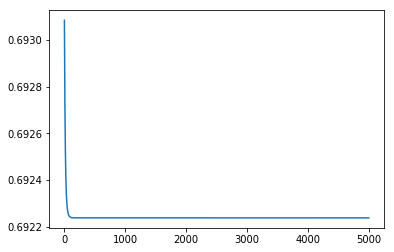

In [4]:
# 训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train = tf.train.GradientDescentOptimizer(0.1).minimize(loss_clf1)
size = dataset.target.shape[0]
labels = dataset.target.reshape(size, 1)
feed = {x: dataset.data, y: labels}

losses_clf1 = []
for i in range(5000):
    sess.run(train, feed)
    losses_clf1.append(sess.run(loss_clf1, feed))

plt.plot(losses_clf1);

In [5]:
def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / len(labels)

# clf1 在训练集上的准确率
preds = sess.run(clf1, feed)
accuracy(preds, labels)

0.54500000000000004

### 1.2 用 tf.contrib.learn.LinearClassifier 实现

In [6]:
clf2 = tf.contrib.learn.LinearClassifier(
    feature_columns=features, model_dir='/tensorflow/temp')

def input_fn():
    return tf.constant(dataset.data), tf.constant(dataset.target)
    
clf2.fit(input_fn=input_fn, steps=10000)

LinearClassifier(params={'joint_weights': False, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7f6d74652748>, 'gradient_clip_norm': None, 'feature_columns': [_RealValuedColumn(column_name='', dimension=2, default_value=None, dtype=tf.float32, normalizer=None)], 'optimizer': None})

In [7]:
# clf2 模型评估（训练集上）
res_clf2 = clf2.evaluate(input_fn=input_fn, steps=1)
res_clf2

{'accuracy': 0.54500002,
 'accuracy/baseline_label_mean': 0.5,
 'accuracy/threshold_0.500000_mean': 0.54500002,
 'auc': 0.52509999,
 'global_step': 59400,
 'labels/actual_label_mean': 0.5,
 'labels/prediction_mean': 0.5,
 'loss': 0.69223702,
 'precision/positive_threshold_0.500000_mean': 0.54455447,
 'recall/positive_threshold_0.500000_mean': 0.55000001}

## 2. 单隐层神经网络

### 2.1 用 tf 基础功能实现

In [8]:
# 定义模型和损失函数 
# x、y 定义同 1.1 节
num_units = 4  # 隐层节点数

# 输入层 -> 隐层 参数
W1 = tf.Variable(tf.random_uniform([2, num_units]), name='W1', dtype=tf.float32)
b1 = tf.Variable(tf.random_uniform([num_units]), name='b1', dtype=tf.float32)

# 隐层 -> 输出层 参数
W2 = tf.Variable(tf.random_uniform([num_units, 1]), name='W2', dtype=tf.float32)
b2 = tf.Variable(tf.random_uniform([1]), name='b2', dtype=tf.float32)

hidden = tf.tanh(tf.matmul(x, W1) + b1)
nn_raw = tf.matmul(hidden, W2) + b2
nn = tf.sigmoid(nn_raw)
loss_nn = tf.losses.sigmoid_cross_entropy(y, nn_raw)  # 需要用 logits

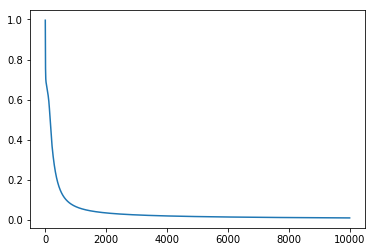

In [9]:
# 训练
sess.run(tf.global_variables_initializer())
train = tf.train.GradientDescentOptimizer(0.3).minimize(loss_nn)
losses_nn = []
for i in range(10000):
    sess.run(train, feed)
    losses_nn.append(sess.run(loss_nn, feed))

plt.plot(losses_nn);

In [10]:
# nn 在训练集上的准确率
preds = sess.run(nn, feed)
accuracy(preds, labels)

1.0

### 2.2 用 tf.contrib.learn.DNNClassifier 实现

In [11]:
num_units_list = [2, 4, 8]  # 尝试不同的隐层节点数
dnns = [tf.contrib.learn.DNNClassifier(feature_columns=features,
                                       hidden_units=[i],
                                       n_classes=2,
                                       activation_fn=tf.tanh) for i in num_units_list]

for dnn in dnns:
    dnn.fit(x=dataset.data, y=dataset.target, steps=10000)

/usr/local/lib/python3.4/dist-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


In [12]:
# dnn 模型评估（训练集上）
res_dnns = [dnn.evaluate(input_fn=input_fn, steps=1) for dnn in dnns]
res_dnns

[{'accuracy': 0.88499999,
  'accuracy/baseline_label_mean': 0.5,
  'accuracy/threshold_0.500000_mean': 0.88499999,
  'auc': 0.87674993,
  'global_step': 10000,
  'labels/actual_label_mean': 0.5,
  'labels/prediction_mean': 0.50280827,
  'loss': 0.31636354,
  'precision/positive_threshold_0.500000_mean': 0.82905984,
  'recall/positive_threshold_0.500000_mean': 0.97000003},
 {'accuracy': 0.995,
  'accuracy/baseline_label_mean': 0.5,
  'accuracy/threshold_0.500000_mean': 0.995,
  'auc': 0.99999988,
  'global_step': 10000,
  'labels/actual_label_mean': 0.5,
  'labels/prediction_mean': 0.51479357,
  'loss': 0.059400775,
  'precision/positive_threshold_0.500000_mean': 1.0,
  'recall/positive_threshold_0.500000_mean': 0.99000001},
 {'accuracy': 1.0,
  'accuracy/baseline_label_mean': 0.5,
  'accuracy/threshold_0.500000_mean': 1.0,
  'auc': 1.0,
  'global_step': 10000,
  'labels/actual_label_mean': 0.5,
  'labels/prediction_mean': 0.50278449,
  'loss': 0.016768061,
  'precision/positive_thresho

## 3. 绘制决策界面

/usr/local/lib/python3.4/dist-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


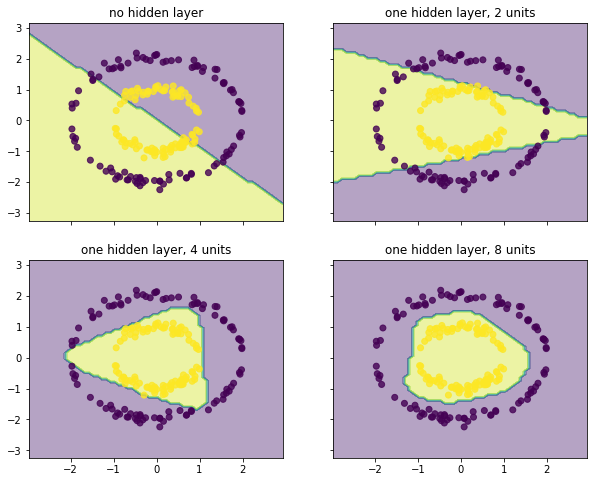

In [13]:
from itertools import product

X = dataset.data
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]), 
                        [clf2] + dnns,
                        ['no hidden layer', 
                         'one hidden layer, 2 units',
                         'one hidden layer, 4 units', 
                         'one hidden layer, 8 units',]):

    Z = np.array(list(clf.predict(np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=dataset.target, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [14]:
writer = tf.summary.FileWriter("/tensorflow/tf", graph=tf.get_default_graph())